In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [3]:
def crosscorr_mat(trial_mat, inds = np.arange(-29,29)):
    inds = np.arange(-29,30)
    cc_mat = np.nan*np.zeros([trial_mat.shape[0], trial_mat.shape[0], trial_mat.shape[-1], inds.shape[0]])
    for cell in range(trial_mat.shape[1]):
        for trial0 in range(trial_mat.shape[0]):
            for trial1 in range(trial_mat.shape[0]):
                tmp = np.correlate(trial_mat[trial0,:,cell],trial_mat[trial1,:,cell],mode='full')
#                 if np.amax(tmp)>.2:
                cc_mat[trial0,trial1,cell,:]= tmp
    return cc_mat, inds

def pv_crosscorr(trial_mat):
    
    tm_z = sp.stats.zscore(trial_mat, axis=-1)

    n_trials, n_pos, n_cells = trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[-1]  
    cc_mat = np.zeros((n_trials, n_trials, 2*n_pos-1))
    for t,tp in product(range(n_trials), range(n_trials)):

        _z_t, _z_tp = tm_z[t,:,:], tm_z[tp,:,:]
        z_t, z_tp = np.zeros((n_pos*3-2,n_cells)), _z_tp[:,:]
        z_t[n_pos-1:2*n_pos-1,:] = _z_t
        for shift in range(0, 2*n_pos-1):
            cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)

    return cc_mat

def crosscorr_res(sess):
    trial_mat = sp.ndimage.filters.gaussian_filter1d(sess.trial_matrices['spks_norm'],1,axis=1)
    trial_mat[np.isnan(trial_mat)]=1E-5
    
    cc_mat = pv_crosscorr(trial_mat)
    return {'cc_mat': cc_mat,
            'trial_info': sess.trial_info,
            'speed': np.nanmean(sess.trial_matrices['speed'], axis=1)
           }

def cc_com(cc_mat, inds = np.arange(-29,30)):
    return np.nansum(cc_mat*inds[np.newaxis,np.newaxis,:], axis=-1)/(np.nansum(cc_mat,axis=-1)+1E-3)

In [4]:
loop_crosscorr = u.loop_func_over_days(crosscorr_res, np.arange(5))

ko_res = {mouse:loop_crosscorr(mouse) for mouse in ko_mice}
ctrl_res = {mouse:loop_crosscorr(mouse) for mouse in ctrl_mice}

np.save("pv_crosscorr.npy", {'ko_res': ko_res, 'ctrl_res': ctrl_res})



{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
<ipython-input-3-9c9d0b0afefc>:24: RuntimeWarning: Mean of empty slice
  cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 's

In [4]:
res = np.load("./pv_crosscorr.npy", allow_pickle=True).all()

In [63]:
lr = res['ctrl_res'][ctrl_mice[0]][0]['trial_info']['LR']

cc_nov = res['ctrl_res'][ctrl_mice[0]][0]['cc_mat'][lr==-1,:,:][:,lr==-1,:]

In [64]:
print(cc_nov.shape)

(19, 19, 59)


(19, 19)
(19, 19)
(20, 20)
(19, 19)
(19, 19)
(22, 22)
(18, 18)
(17, 17)
(17, 17)
(7, 7)


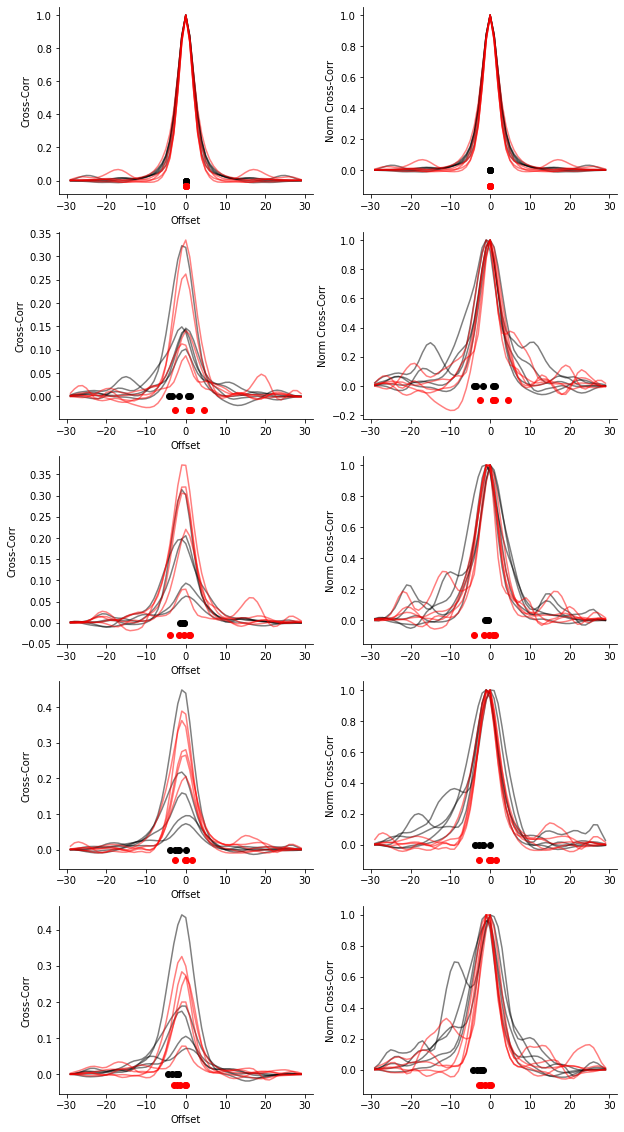

In [172]:
fig, ax = plt.subplots(5,2, figsize=[10,20])

x = np.arange(-29,30)
nov = [-1,1,-1,1,-1]


for mouse, _nov in zip(ctrl_mice,nov):
    lr = res['ctrl_res'][mouse][0]['trial_info']['LR']
    cc_nov = res['ctrl_res'][mouse][0]['cc_mat'][lr==_nov,:,:][:,lr==_nov,:]
    nov_com = cc_com(cc_nov)
    print(nov_com.shape)
    for trial in range(0,5):
        ax[trial,0].plot(x,cc_nov[trial,0,:], color = 'black',alpha = .5)
        ax[trial,1].plot(x,cc_nov[trial,0,:]/np.amax(cc_nov[0,trial,:]), color = 'black', alpha=.5)

        ax[trial,1].scatter(nov_com[trial,0],0,c='black', alpha = 1)
        ax[trial,0].scatter(nov_com[trial,0],0,c='black', alpha = 1)
        
        ax[trial,0].set_ylabel('Cross-Corr')
        ax[trial,0].set_xlabel('Offset')
        ax[trial,1].set_ylabel('Norm Cross-Corr')
        
        ax[trial,0].spines['top'].set_visible(False)
        ax[trial,0].spines['right'].set_visible(False)
        ax[trial,1].spines['top'].set_visible(False)
        ax[trial,1].spines['right'].set_visible(False)



for mouse, _nov in zip(ko_mice, nov):
    lr = res['ko_res'][mouse][0]['trial_info']['LR']
    cc_nov = res['ko_res'][mouse][0]['cc_mat'][lr==_nov,:,:][:,lr==_nov,:]
    nov_com = cc_com(cc_nov)
    print(nov_com.shape)
    for trial in range(0,5):
        ax[trial,0].plot(x,cc_nov[trial,0,:], color = 'red', alpha=.5)
        ax[trial,1].plot(x,cc_nov[trial,0,:]/np.amax(cc_nov[0,trial,:]), color = 'red',alpha=.5)
        ax[trial,1].scatter(nov_com[trial,0],-.1,c='red', alpha = 1)
        ax[trial,0].scatter(nov_com[trial,0],-.03,c='red', alpha = 1)
#         ax[trial,1].vlines(nov_com[0,trial],0,1,color='red', alpha = 1)


fig.savefig(os.path.join(figdir,"trial0ref_crosscorr.pdf"),format = 'pdf')

In [5]:
sess = u.load_single_day(ctrl_mice[0],0)
print(sess.novel_arm)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
-1


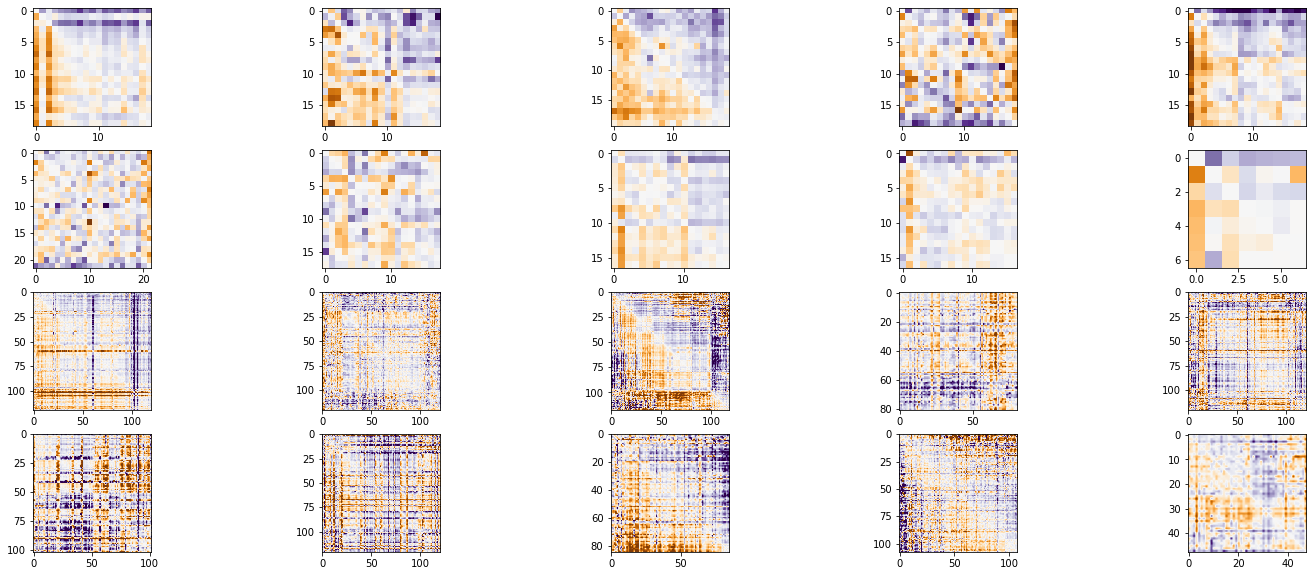

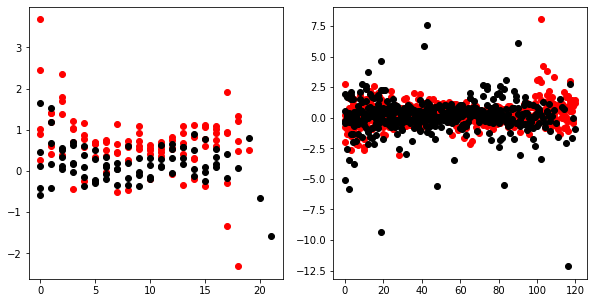

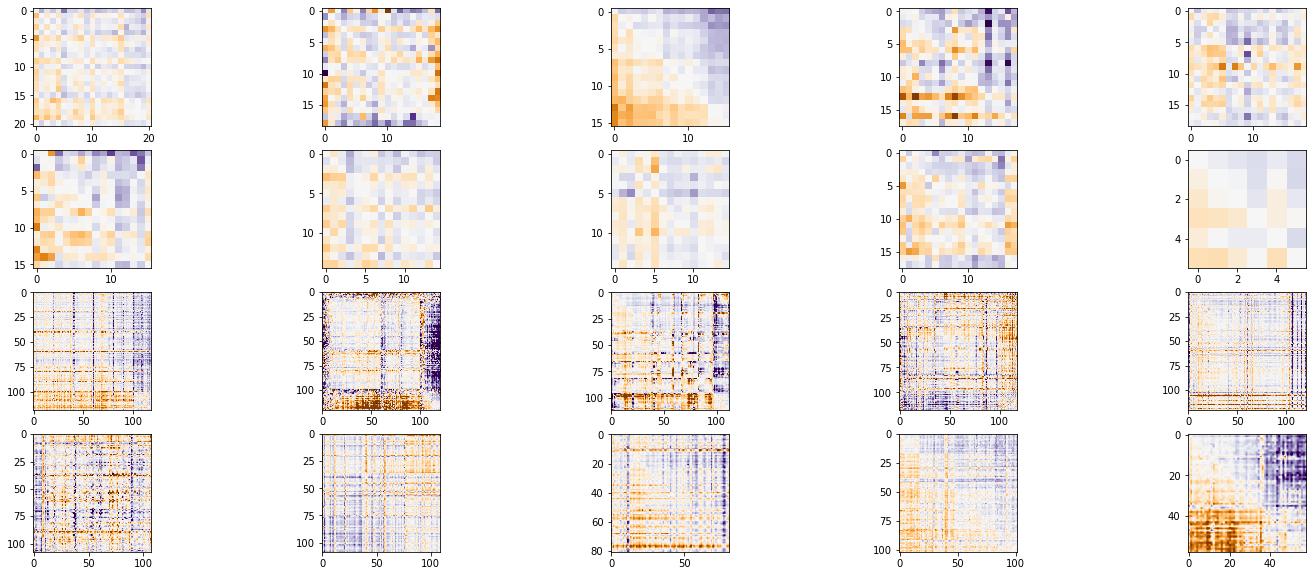

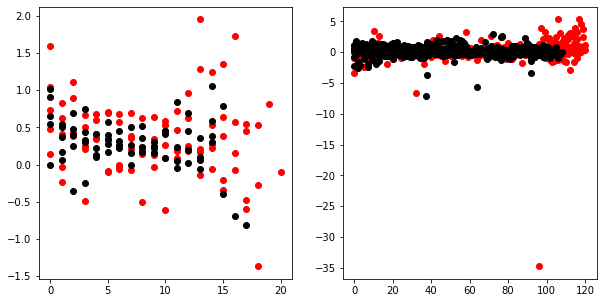

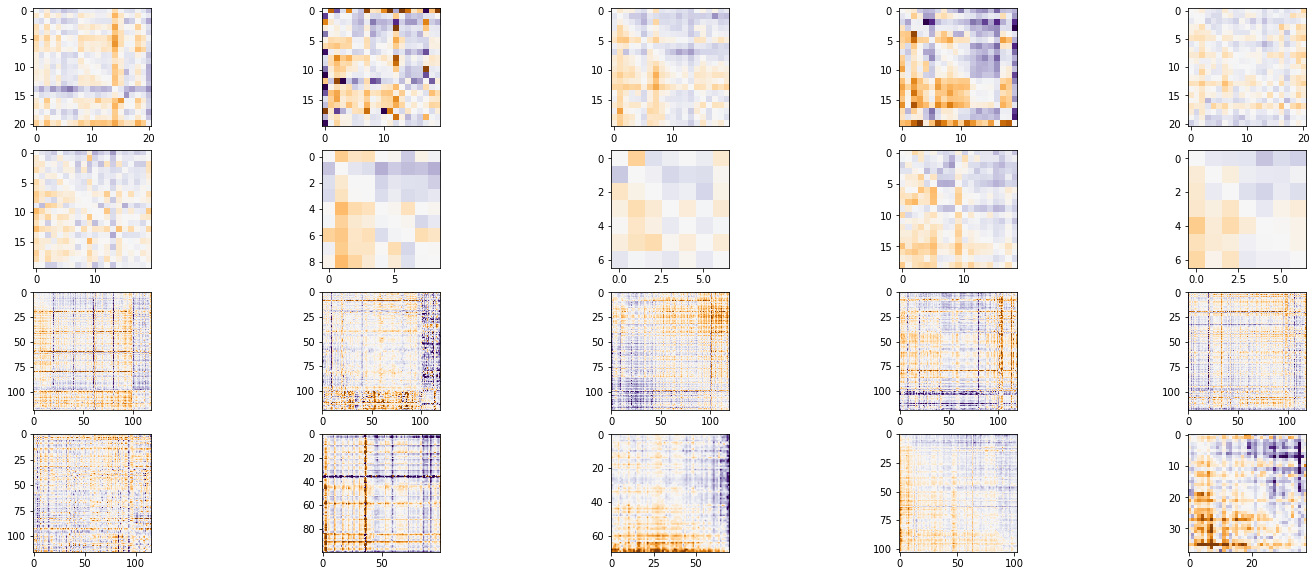

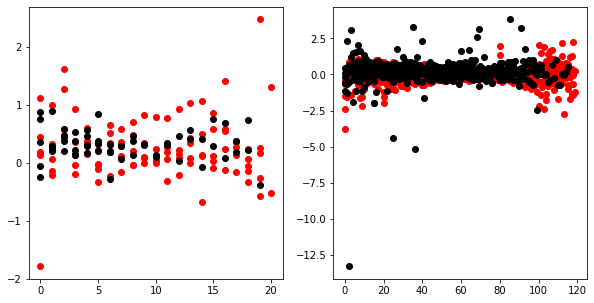

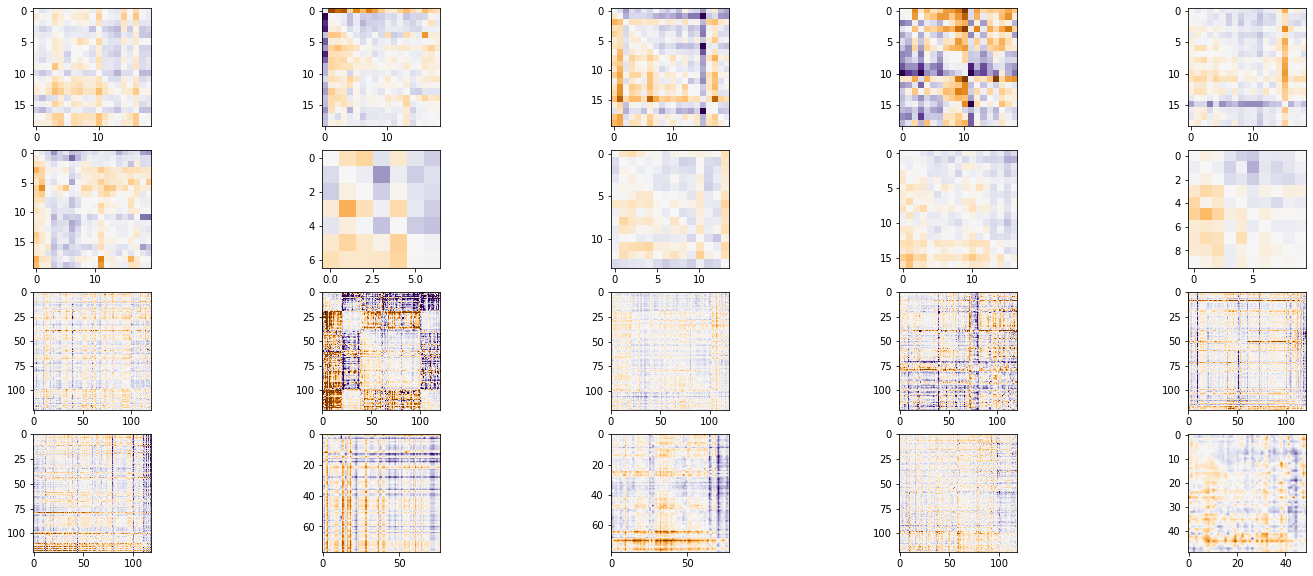

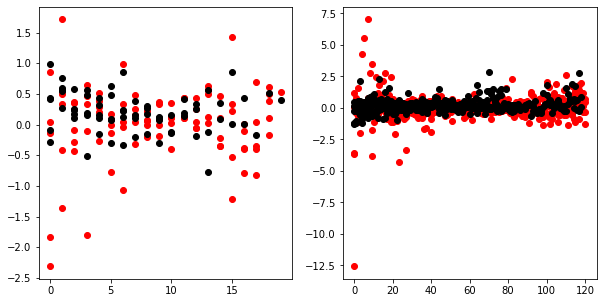

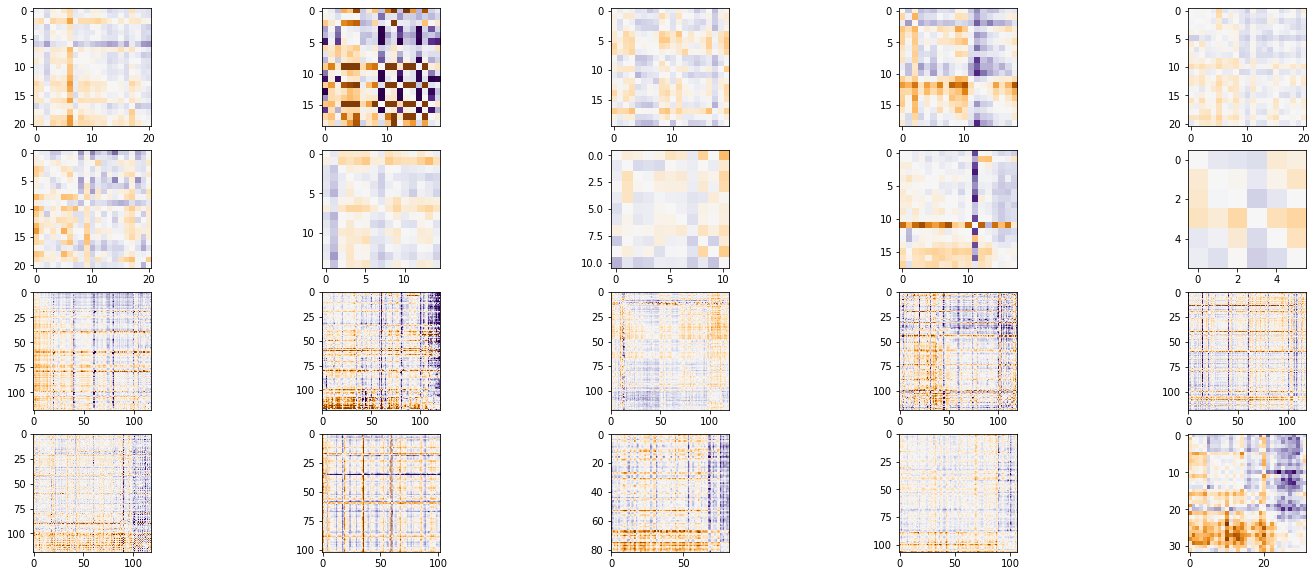

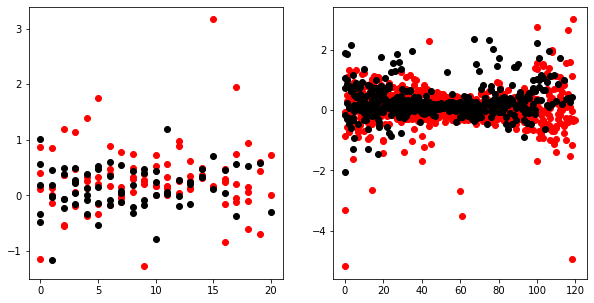

In [127]:
days_z = sp.stats.zscore(np.arange(5))
df = pd.DataFrame({'mouse': [],
                       'day': [],
                       'dz': [],
                       'ko': [],
                       'ko_x_day': [],
                       'nov': [],
                       'nov_x_day': [],
                       'nov_x_ko': [],
                       'shift': [],
                       'speed': [],
                       'intercept': 1})

# df_fam = pd.DataFrame({'mouse': [],
#      'day': [],
#      'dz': [],
#      'ko': [],
#      'shift': [],
#      })

nov_arm = [-1, 1, -1, 1, -1]
color= ['red', 'black']
nov_shift_means = np.zeros([2,5,5])
nov_shift_avgmat = np.zeros([2,5,5,5,5])

fam_shift_means = np.zeros([2,5,5])
fam_shift_avgmat = np.zeros([2,5,5,20,20])

for day in range(5):
    fig_cc, ax_cc = plt.subplots(4,5,figsize=[25,10])
    fig_sh, ax_sh = plt.subplots(1,2, figsize = [10,5])
    
    for row, (mice, _res) in enumerate(zip([ctrl_mice, ko_mice], [res['ctrl_res'], res['ko_res']])):
        for m, mouse in enumerate(mice):
            cc_mat = _res[mouse][day]['cc_mat']
            lr, block_number, speed = _res[mouse][day]['trial_info']['LR'], _res[mouse][day]['trial_info']['block_number'], _res[mouse][day]['speed']

            nov_mat = cc_mat[lr==nov_arm[m],:,:][:,lr==nov_arm[m],:]
#             nov_com = cc_com(nov_mat)
            nov_com = cc_com(nov_mat[:,:,9:-9], inds = np.arange(-20,21))
            ax_cc[row,m].imshow(nov_com,vmin=-5, vmax=5, cmap='PuOr')
            
            nov_shift = (nov_com*(np.tril(-1*np.ones(nov_com.shape),k=-1) + np.triu(np.ones(nov_com.shape), k=0))).mean(axis=0)
            ax_sh[0].scatter(np.arange(0,nov_shift.shape[0]),nov_shift, color=color[row])
            nov_shift_means[row,m, day] = np.nanmean(nov_shift[:5])
            
            nov_speed = speed[lr==nov_arm[m]]
#             df_nov = df_nov.append({'mouse': m + row*5, 'day': day, 'dz': days_z[day], 'ko': row, 'shift': np.nanmean(nov_shift[:5])}, ignore_index=True)
#             for trial in range(5):
            df = df.append({'mouse': m + row*5, 
                                    'day': day, 
                                    'dz': days_z[day], 
                                    'ko': row, 
                                    'ko_x_day': row*days_z[day], 
                                    'nov': 1,
                                    'nov_x_day': days_z[day],
                                    'nov_x_ko': row,
                                    'shift': np.nanmean(nov_shift[:5]),
                                    'speed': np.nanmean(nov_speed[:5]),
                                    'intercept': 1,
                                   }, ignore_index=True)
            nov_shift_avgmat[row,day,m, :,:] = nov_com[:5,:5]
            
            
            fam_mat = cc_mat[lr==-1*nov_arm[m],:,:][:,lr==-1*nov_arm[m],:]
#             fam_com = cc_com(fam_mat)
            fam_com = cc_com(fam_mat[:,:,9:-9], inds = np.arange(-20,21))
            ax_cc[row+2,m].imshow(fam_com,vmin=-5, vmax=5, cmap='PuOr')
            
            fam_shift = (fam_com*(np.tril(-1*np.ones(fam_com.shape),k=-1) + np.triu(np.ones(fam_com.shape), k=0))).mean(axis=0)
            ax_sh[1].scatter(np.arange(0,fam_shift.shape[0]),fam_shift, color=color[row])
            fam_shift_means[row,m, day] = np.nanmean(fam_shift[:20])
            
            fam_speed = speed[lr==-1*nov_arm[m]]
            
#             for trial in range(5):
            df = df.append({'mouse': m + row*5, 
                                    'day': day, 
                                    'dz': days_z[day], 
                                    'ko': row, 
                                    'ko_x_day': row*days_z[day], 
                                    'nov': 0,
                                    'nov_x_day': 0,
                                    'nov_x_ko': 0,
                                    'shift': np.nanmean(fam_shift[:5]),
                                    'speed': np.nanmean(fam_speed[:5]),
                                    'intercept':1,
                                   }, ignore_index=True)
            fam_shift_avgmat[row,day,m, :,:] = fam_com[:20,:20]

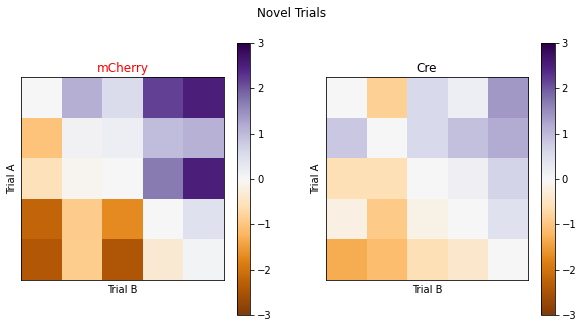

In [137]:
fig, ax = plt.subplots(1,2,figsize= [10,5])

h_l = ax[0].imshow(np.nanmean(nov_shift_avgmat[0,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')
h_r = ax[1].imshow(np.nanmean(nov_shift_avgmat[1,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')

plt.colorbar(h_l, ax= ax[0])
plt.colorbar(h_r, ax = ax[1])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_ylabel('Trial A')
ax[0].set_xlabel('Trial B')

ax[1].set_ylabel('Trial A')
ax[1].set_xlabel('Trial B')

ax[0].set_title('mCherry', color = 'red')
ax[1].set_title('Cre', color = 'black')

fig.suptitle('Novel Trials')
fig.savefig(os.path.join(figdir, 'novel_trials_pv_crosscor_com.pdf'), format = 'pdf')

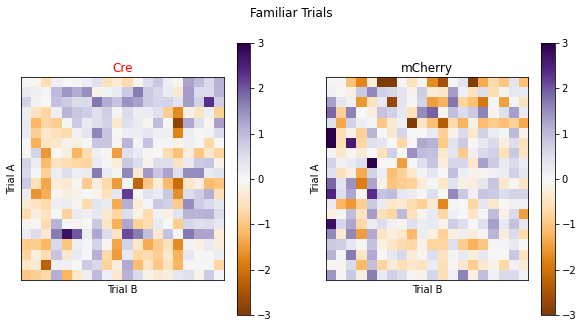

In [138]:
fig, ax = plt.subplots(1,2,figsize= [10,5])

h_l = ax[0].imshow(np.nanmean(fam_shift_avgmat[0,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')
h_r = ax[1].imshow(np.nanmean(fam_shift_avgmat[1,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')

plt.colorbar(h_l, ax= ax[0])
plt.colorbar(h_r, ax = ax[1])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_ylabel('Trial A')
ax[0].set_xlabel('Trial B')

ax[1].set_ylabel('Trial A')
ax[1].set_xlabel('Trial B')

ax[0].set_title('Cre', color = 'red')
ax[1].set_title('mCherry', color = 'black')

fig.suptitle('Familiar Trials')
fig.savefig(os.path.join(figdir, 'fam_trials_pv_crosscor_com.pdf'), format = 'pdf')

In [139]:
df_nov = df[df['day']<3] #[df['nov']==1]
lmm_res = MixedLM(df_nov['shift'], df_nov[['ko','nov', 'dz', 'ko_x_day', 'speed', 'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift   
No. Observations: 60      Method:             REML    
No. Groups:       10      Scale:              0.4538  
Min. group size:  6       Log-Likelihood:     -63.8041
Max. group size:  6       Converged:          No      
Mean group size:  6.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko           0.155    0.342  0.453 0.650 -0.515  0.826
nov          0.718    0.174  4.125 0.000  0.377  1.058
dz          -0.377    0.217 -1.741 0.082 -0.801  0.047
ko_x_day     0.445    0.301  1.475 0.140 -0.146  1.035
speed       -0.754    2.084 -0.362 0.718 -4.838  3.331
intercept   -0.237    0.616 -0.385 0.700 -1.446  0.971
Group Var    0.065    0.174                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

In [140]:
df_fam = df[df['nov']==1]
lmm_res = MixedLM(df_fam['shift'], df_fam[['ko', 'dz', 'ko_x_day', 'speed', 'intercept']], df_fam['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift   
No. Observations: 50      Method:             REML    
No. Groups:       10      Scale:              0.1315  
Min. group size:  5       Log-Likelihood:     -24.7184
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.168    0.142 -1.182 0.237 -0.446  0.110
dz          -0.323    0.075 -4.332 0.000 -0.469 -0.177
ko_x_day     0.252    0.103  2.453 0.014  0.051  0.453
speed       -0.433    1.031 -0.421 0.674 -2.454  1.587
intercept    0.536    0.301  1.783 0.075 -0.053  1.126
Group Var    0.008    0.055                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [141]:

anova_res = mixed_anova(data=df[df['nov']==1], dv='shift', between='ko', within='day', subject='mouse')
print(anova_res)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.225072    1    8  0.225072  1.481791  0.258181        NaN   
1          day  2.381790    4   32  0.595448  5.047394  0.002869    0.03459   
2  Interaction  1.739244    4   32  0.434811  3.685736  0.014075        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.156278       NaN        NaN       NaN       NaN  
1  0.386851  0.547439      False  0.067538  0.020637  
2  0.315405       NaN        NaN       NaN       NaN  


2.616633804152813 0.030811140919905992
0.8782919558795323 0.4053904564862696
-0.15583835347302089 0.880021003250076
-1.2232760286715272 0.2560328335736162
1.0679895896902811 0.3166897030427527


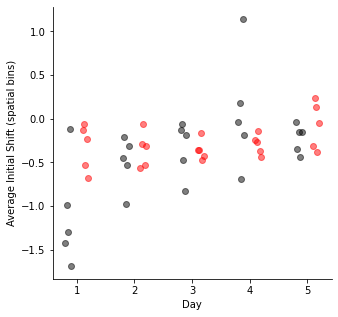

In [173]:
fig, ax = plt.subplots(figsize = [5,5])
for day in range(5):
    t,p = sp.stats.ttest_ind(nov_shift_means[0,:,day], nov_shift_means[1,:,day])
    print(t,p)
#     ax.scatter(10*day+np.linspace(0,.4, num=5), -fam_shift_means[0,:,day], color='black', s= 20)
    ax.scatter(10*day+np.linspace(1,2, num=5), -nov_shift_means[0,:,day], color='black', alpha = .5)#, s=10)
#     ax.scatter(10*day+np.linspace(3,3.4, num=5), -fam_shift_means[1,:,day], color='red', s= 20)
    ax.scatter(10*day+np.linspace(4,5, num=5), -nov_shift_means[1,:,day], color='red', alpha = .5) #, s = 10)
    
    
ax.set_ylabel('Average Initial Shift (spatial bins)')
ax.set_xlabel('Day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(10*np.arange(5) + 3)
ax.set_xticklabels([1, 2, 3, 4, 5])

fig.savefig(os.path.join(figdir,"nov_initial_shifts.pdf"), format = 'pdf')

In [124]:
anova_res = mixed_anova(data=df_fam, dv='shift', between='ko', within='day', subject='mouse')
print(anova_res)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.029940    1    8  0.029940  0.335613  0.578316  0.040263   
1          day  1.947074    4   32  0.486768  8.047398  0.000131  0.501477   
2  Interaction  0.588571    4   32  0.147143  2.432609  0.067622  0.233174   

        eps  
0       NaN  
1  0.570785  
2       NaN  


0.5560091999026889 0.5934100980369195
-0.4981016912614713 0.6318150347363525
-0.7289367762635228 0.48682912207257056
0.21304434809511788 0.836621120467077
-0.4957320656604801 0.6334133893469263


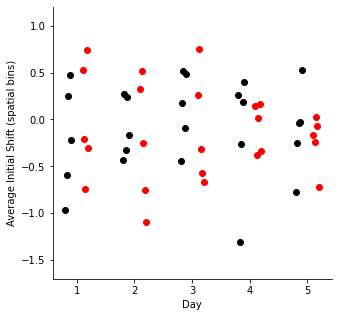

In [174]:
fig, ax = plt.subplots(figsize = [5,5])
for day in range(5):
    t,p = sp.stats.ttest_ind(fam_shift_means[0,:,day], fam_shift_means[1,:,day])
    print(t,p)
    ax.scatter(10*day+np.linspace(1,2, num=5), -fam_shift_means[0,:,day], color='black', alpha = 1)#, s=10)
#     ax.scatter(10*day+np.linspace(3,3.4, num=5), -fam_shift_means[1,:,day], color='red', s= 20)
    ax.scatter(10*day+np.linspace(4,5, num=5), -fam_shift_means[1,:,day], color='red', alpha = 1) #, s = 10
    
ax.set_ylabel('Average Initial Shift (spatial bins)')
ax.set_xlabel('Day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(10*np.arange(5) + 3)
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_ylim(-1.7,1.2)
    
fig.savefig(os.path.join(figdir,"fam_initial_shifts.pdf"), format = 'pdf')